# Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
5. 4square_channel.png Four square = imagery, surface, bed&surface, change
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
import fiona
from shapely.ops import nearest_points
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib as mpl
import pickle
import string

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [3]:
xgrid = np.arange(-382000,-374000,2000)


## 4. thickness_surfacecolour.png
profile depth

In [4]:
x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_x.npy')
y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_y.npy')
it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_ice_thickn.npy')
ib_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_icebase.npy')

In [5]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
# /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im[im==-9999] = np.nan
    im = im / duration
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)

x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d
    

In [6]:
df.loc[nid1].fileurl

'http://data.pgc.umn.edu/elev/dem/setsm/REMA/geocell/v1.0/2m/s83w153/SETSM_WV02_20121224_103001001D86CA00_103001001D886000_seg1_2m_v1.0.tar.gz'

In [7]:
# direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

# xv = np.load(direc + 'x_grid' +'.npy')
# yv = np.load(direc + 'y_grid' +'.npy')
# thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
# extent_l2l = np.load(direc +'extent.npy')
# ice_base = np.load(direc +'_ice_base.npy')


In [8]:
# # Load ice base interpolated from radar results
# direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_gridded_'

# xv = np.load(direc + 'x_grid' +'.npy')
# yv = np.load(direc + 'y_grid' +'.npy')
# thickness_interpolated = np.load(direc +'ice_thickn.npy')
# extent_l2l = np.load(direc +'extent.npy')
# ice_base = np.load(direc +'ice_base.npy')
# ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [9]:
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

In [10]:
# xmin, xmax, ymin, ymax = extent_l2l

In [11]:
# xmin = -382700

In [12]:
print(xmin, xmax, ymin, ymax)

-382700 -374781.9 -734075.1 -721770.2


In [13]:
1

1

## Plot it

In [14]:
it = it_new[50,:]
ib = ib_new[50,:]
x = x_new[50,:]
y = y_new[50,:]
mid = pd.DataFrame({'x': x,'y':y,'ice_thickn':it,'ice_base':ib})

points = [Point(xy) for xy in zip(mid.x,mid.y)]
gdf_mid = gpd.GeoDataFrame(mid,geometry=points,crs="EPSG:3031")

In [15]:
# mpl.rcParams['font.size']=10
# plt.figure(figsize=(10,10))
# plt.plot(x,it)
# plt.plot(points_x_surveyed[50,:],ice_thickn_surveyed[50,:],'x')
# plt.grid()
# plt.ylim(400,500)
# plt.show()

In [16]:
!ls /Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP

highres_bed_channel_surveyed.npy
highres_chan_surf.npy
highres_gridded_extent.npy
highres_gridded_ice_base.npy
highres_gridded_ice_thickn.npy
highres_gridded_REMA_surf.npy
highres_gridded_x_grid.npy
highres_gridded_y_grid.npy
highres_ice_base_line2line.tif
highres_ice_thickn_channel.npy
highres_line2line_interpbydist_extent.npy
highres_line2line_interpbydist_icebase.npy
highres_line2line_interpbydist_ice_thickn.npy
highres_line2line_interpbydist_points_x.npy
highres_line2line_interpbydist_points_y.npy
highres_line2line_interpbydist_REMAsurf.npy
highres_points_x_channel.npy
highres_points_y_channel.npy
highres_surf_channel_surveyed.npy
highres_thickness_line2line.tif
ice_base_mitgcm.npy
ice_base_no_chan.pkl
ice_base_smooth_mitgcm.npy
picked_bed_metadata.csv
sea_level_below_surf_corrected.npy
smoo_ice_base_mitgcm.npy
smoo_ice_base_smooth_mitgcm.npy
smooth4_mitgcm_icebase.npy
smooth4_mitgcm_ice_thickn_channel.npy
smooth4_mitgcm_ice_thickn.npy
smooth4_mitgcm_points_x_channel.npy
smooth4_mi

In [17]:
points_x_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_x_channel.npy')
points_y_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_points_y_channel.npy') 
ice_thickn_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_ice_thickn_channel.npy')
base_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_bed_channel_surveyed.npy')

In [18]:
# plt.plot(x,np.mean(ib_new[5:15,:],0))

In [19]:
import pickle
with open('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/bullseye.pkl', "rb") as poly_file:
    bullseye = pickle.load(poly_file)

In [20]:
bullseye_array = np.array(bullseye.exterior.coords.xy )

In [21]:
# 12 original points with 399 inbeween

In [22]:
tmp_dfp = [Point.distance(gdf_mid.geometry.iloc[i]) for i,Point in enumerate(gdf_mid.geometry.iloc[1:])]
tmp_dfp[:0] = [0]
gdf_mid['dx'] = pd.Series(tmp_dfp) #note the 1:, equivalent to i+1
gdf_mid['distan_cum'] = gdf_mid.dx.cumsum()

f = sp.interpolate.interp1d(gdf_mid.y,gdf_mid.distan_cum)

distan_cum_surveyed = f(points_y_surveyed[50,:])

gdf_mid['in_meltzone'] = gdf_mid.geometry.intersects(bullseye)
gdf_mz = gdf_mid[gdf_mid.in_meltzone==True].copy()

In [23]:
gdf_mz.keys()

Index(['x', 'y', 'ice_thickn', 'ice_base', 'geometry', 'dx', 'distan_cum',
       'in_meltzone'],
      dtype='object')

In [24]:
# gdf_mid.to_file('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/mid_chan_interpd.shp')

In [25]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

In [26]:
bbox = box(xmin, xmax, ymin, ymax )
#groundingline
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

In [27]:
radarlines_paths = sorted(glob.glob("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/*.shp"))
toremove = ['/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line0KIS1.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line0bKIS1.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/lineseis34.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1011.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1213.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1415.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line9.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right1112.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right13.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right1314.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right910.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line10.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line11.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line12.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line13.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line14.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line7.shp']                        
for i in toremove:
    radarlines_paths.remove(i)
radarlines_paths.append('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line7.gpkg')

radarlines = [gpd.read_file(radarline) for radarline in radarlines_paths]

In [28]:
#smooth REMA dem for contours
im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
del im_REMA_d,im_REMA_c

In [29]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

In [30]:
bbox = box(xmin, xmax, ymin, ymax )
#groundingline
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


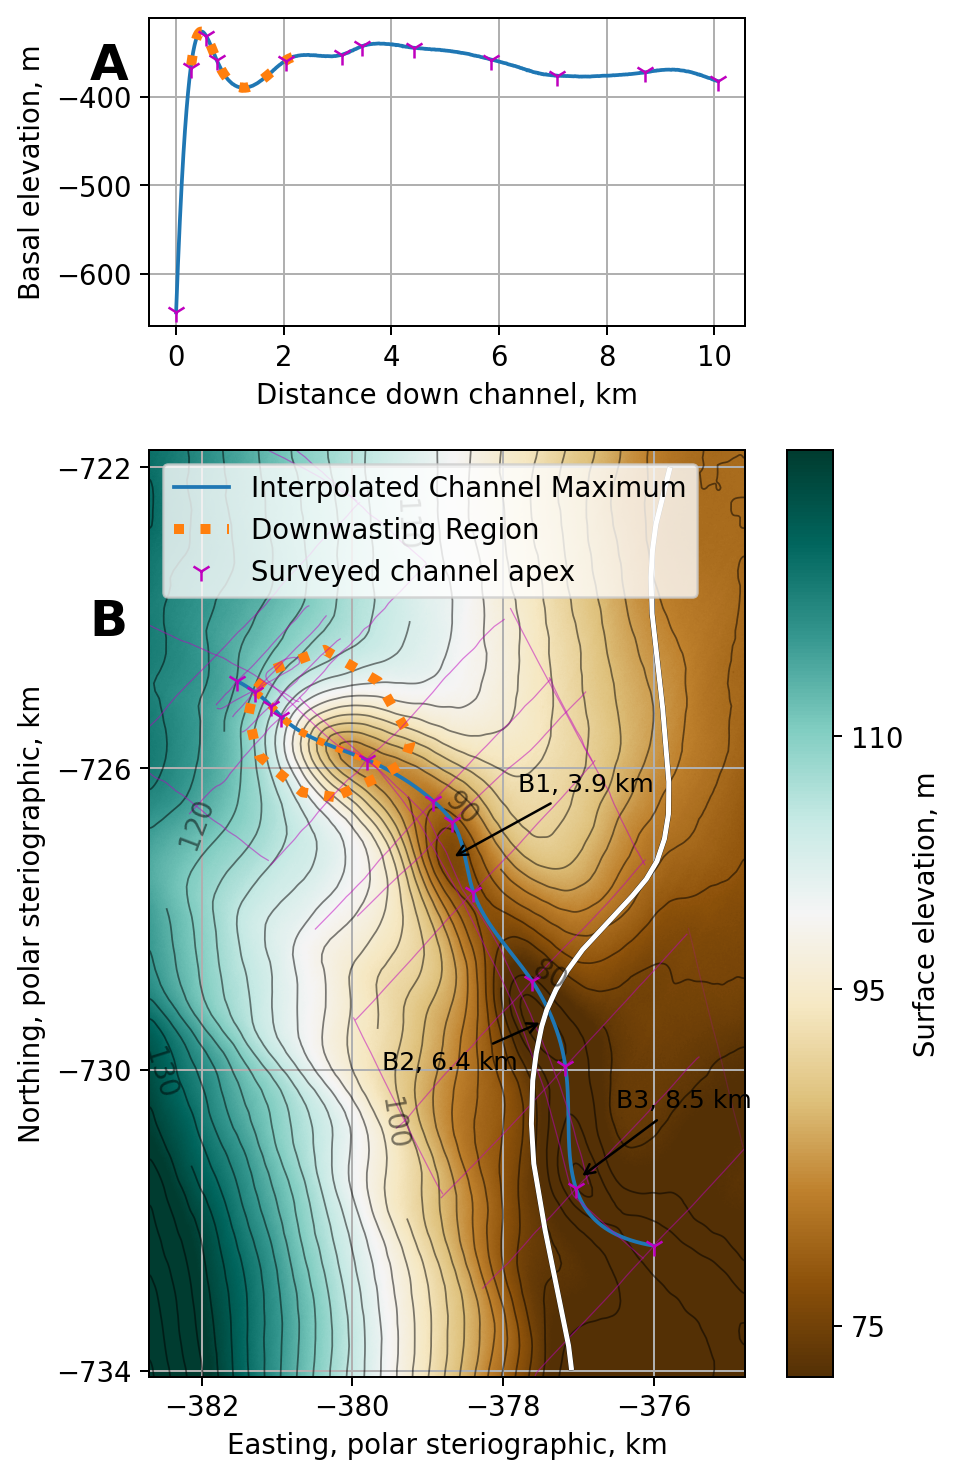

In [65]:
# %matplotlib qt
#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

samp=50

font = {'size'   : 11}

mpl.rc('font', **font)




fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 3]},
                               figsize=[6,10],dpi=180)#rema ,constrained_layout=True


ax1.plot(gdf_mid.distan_cum/1000,gdf_mid.ice_base+geoid_correction+res_correction + res_correction)
# ax1.plot( gdf_mid.distan_cum.iloc[39],gdf_mid.ice_base.iloc[39],'b1',label="downwasting centre",markersize=15,markeredgewidth=2)
ax1.plot(gdf_mz.distan_cum/1000,gdf_mz.ice_base+geoid_correction+res_correction + res_correction,':',label="Downwasting region",
         color='tab:orange',linewidth=4) #,linewidth=3,markersize=15,markeredgewidth=2,
ax1.plot(distan_cum_surveyed/1000,base_surveyed[50,:]+geoid_correction+res_correction + res_correction,'1',
          label="Surveyed channel apex",markersize=8,color="m")
# ax1.set_xlim([xmin, xmax])
# ax1.set_ylim([ymin,ymax])
ax1.set_ylabel('Basal elevation, m')
ax1.set_xlabel('Distance down channel, km')
ax1.grid()



a2 = ax2.imshow(im_REMA+geoid_correction+res_correction ,extent=np.array(extent_REMA)/1000,vmin=25+geoid_correction ,
                vmax=80+geoid_correction , cmap='BrBG')
# CS1 =  ax2.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction+res_correction,
#                       30,vmin=15+geoid_correction+res_correction,vmax=90+geoid_correction+res_correction , 
# #                   cmap='BrBG',
#                   colors='black',
#                   alpha=0.5,linewidths=0.7)

# ax2.clabel(CS1,CS1.levels[0::4], inline=1,  fmt='%i')

CS1 =  ax2.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
                      30,vmin=15+geoid_correction ,vmax=90+geoid_correction, 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)

ax2.clabel(CS1,CS1.levels[0::4], inline=1,  fmt='%i')

ax2.plot( gdf_mid.x/1000,gdf_mid.y/1000,label='Interpolated Channel Maximum')
ax2.plot(bullseye_array[0]/1000,bullseye_array[1]/1000,':',label="Downwasting Region",color='tab:orange',linewidth=4) #,markersize=15,markeredgewidth=2
ax2.plot(gdf_mz.x/1000,gdf_mz.y/1000,':',markersize=4,color='tab:orange',linewidth=3) #,markersize=15,markeredgewidth=2
ax2.plot(points_x_surveyed[50,:]/1000,points_y_surveyed[50,:]/1000,'1',markersize=8,
         label="Surveyed channel apex",
         color="m")

#plot faint radarlines
for i,rl in enumerate(radarlines):
    if i ==0:
        ax2.plot(rl.geometry.x/1000,rl.geometry.y/1000,'m-',
#                  label='Radar profiles',
                 linewidth=0.5,alpha=0.2)
    else:
        ax2.plot(rl.geometry.x/1000,rl.geometry.y/1000,'m-',linewidth=0.5,alpha=0.5)

ax2.annotate( 'B1, 3.9 km',(-378.7, -727.2),xytext=(-378.8+1, -727.3+1),arrowprops=dict(arrowstyle='->'),fontsize=10)
ax2.annotate( 'B2, 6.4 km',(-377.45, -729.35),xytext=(-377.6-2, -729.5-0.5),arrowprops=dict(arrowstyle='->'),fontsize=10)
ax2.annotate( 'B3, 8.5 km',(-377.0, -731.45),xytext=(-377.5+1, -731.5+1),arrowprops=dict(arrowstyle='->'),fontsize=10)

ax2.set_xlim([xmin/1000, xmax/1000])
ax2.set_ylim([ymin/1000,ymax/1000])
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.grid()
ax2.set_xlabel('Easting, polar steriographic, km')
ax2.set_ylabel('Northing, polar steriographic, km')

ax2.plot(gl[:,0]/1000,gl[:,1]/1000,'k-',linewidth=2.2)
ax2.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',
#          label='Grounding Line',
         linewidth=2)
# ax2.set_xticks(xgrid/1000)
ax2.legend(loc='upper left')

cb1 = fig.colorbar(a2,ax=ax2)
cb1.set_label('Surface elevation, m')
cb1.set_ticks(np.round(np.linspace(15+geoid_correction+res_correction ,90+geoid_correction+res_correction ,5)/5)*5)

(x0, y0), (x1, y1) = ax2.get_position().get_points() 
(x20, y20), (x21, y21) = ax1.get_position().get_points() 
ax1.set_position([x0, y20, x1-x0,y21-y20 ])  # x, y, width, height

# #write A B C D from a loop
for n, a in enumerate((ax1, ax2)):
    a.text(-0.1, 0.8, string.ascii_uppercase[n], transform=a.transAxes, 
            size=20, weight='bold')

fig.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/thickness_surfacecolour.png')
fig.show()

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


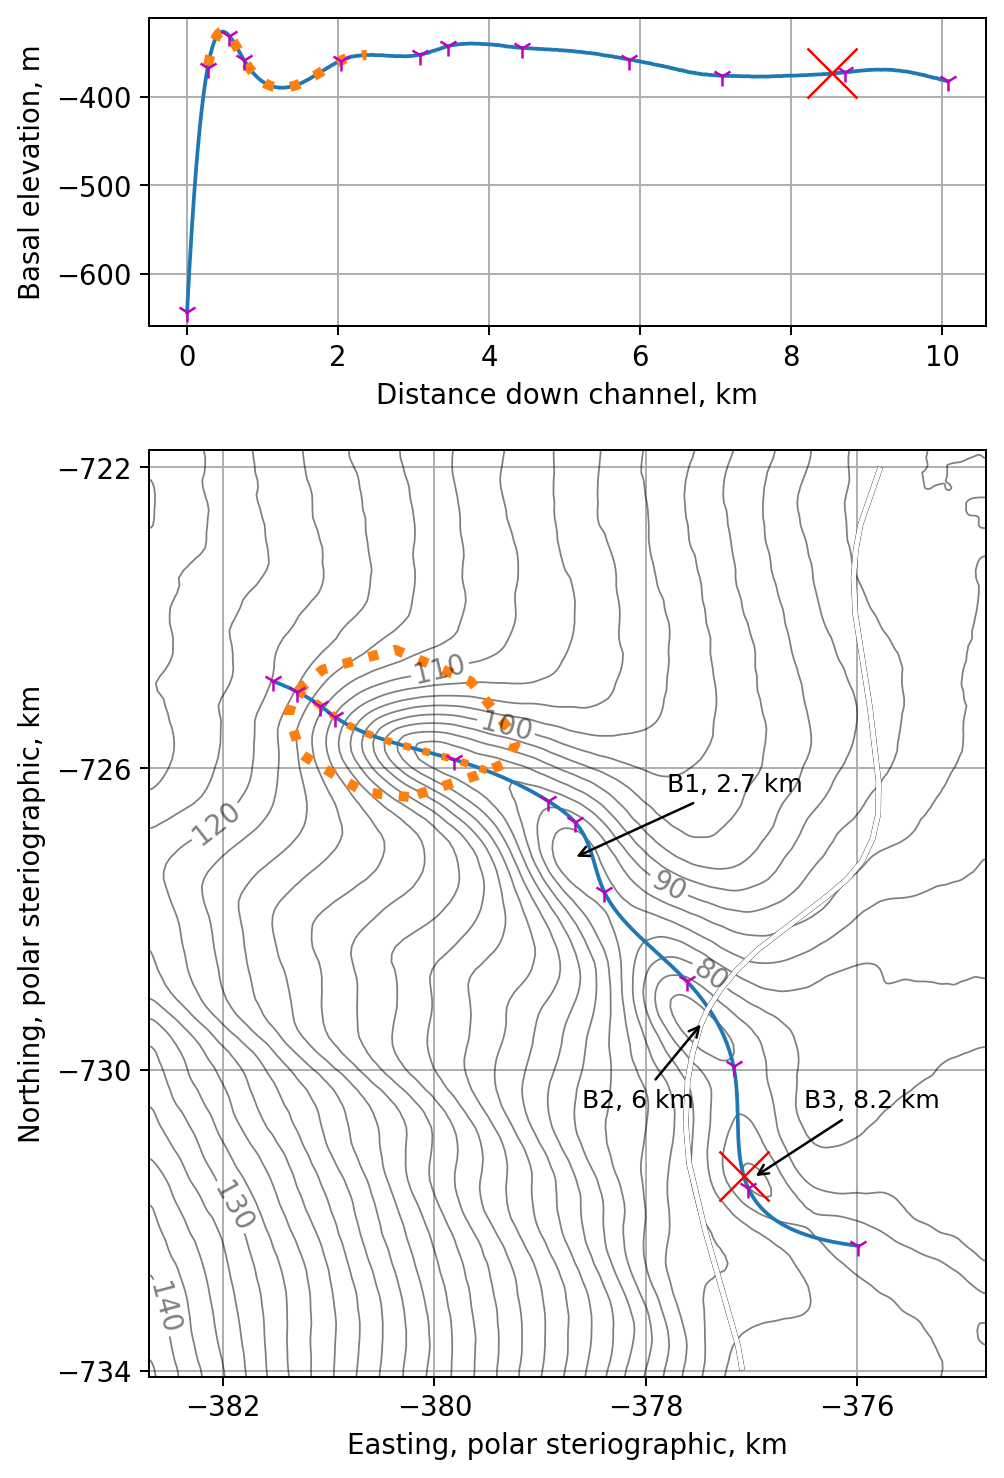

In [61]:
# Figure out distances to B1-3
#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

samp=50



di = 3750 #2800 #1700


fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 3]},
                               figsize=[6,10],dpi=180)#rema ,constrained_layout=True
font = {'size'   : 11}

mpl.rc('font', **font)


ax1.plot(gdf_mid.distan_cum/1000,gdf_mid.ice_base+geoid_correction+res_correction + res_correction)
# ax1.plot( gdf_mid.distan_cum.iloc[39],gdf_mid.ice_base.iloc[39],'b1',label="downwasting centre",markersize=15,markeredgewidth=2)
ax1.plot(gdf_mz.distan_cum/1000,gdf_mz.ice_base+geoid_correction+res_correction + res_correction,':',label="Downwasting region",
         color='tab:orange',linewidth=4) #,linewidth=3,markersize=15,markeredgewidth=2,
ax1.plot(distan_cum_surveyed/1000,base_surveyed[50,:]+geoid_correction+res_correction + res_correction,'1',
          label="Surveyed channel apex",markersize=8,color="m")
ax1.plot(gdf_mid.distan_cum.iloc[di]/1000,gdf_mid.ice_base.iloc[di]+geoid_correction+res_correction + res_correction,
         'x',
          label="Surveyed channel apex",markersize=20,color="red")
# ax1.set_xlim([xmin, xmax])
# ax1.set_ylim([ymin,ymax])
ax1.set_ylabel('Basal elevation, m')
ax1.set_xlabel('Distance down channel, km')
ax1.grid()



CS1 =  ax2.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
                      30,vmin=15+geoid_correction ,vmax=90+geoid_correction, 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)

ax2.clabel(CS1,CS1.levels[0::4], inline=1,  fmt='%i')

ax2.plot( gdf_mid.x/1000,gdf_mid.y/1000,label='Interpolated Channel Maximum')
ax2.plot( gdf_mid.x.iloc[di]/1000,gdf_mid.y.iloc[di]/1000,
         'x',color='red',markersize=20)
ax2.plot(bullseye_array[0]/1000,bullseye_array[1]/1000,':',label="Downwasting Region",color='tab:orange',linewidth=4) #,markersize=15,markeredgewidth=2
ax2.plot(gdf_mz.x/1000,gdf_mz.y/1000,':',markersize=4,color='tab:orange',linewidth=3) #,markersize=15,markeredgewidth=2
ax2.plot(points_x_surveyed[50,:]/1000,points_y_surveyed[50,:]/1000,'1',markersize=8,
         label="Surveyed channel apex",
         color="m")


ax2.annotate( 'B1, 2.7 km',(-378.7, -727.2),xytext=(-378.8+1, -727.3+1),arrowprops=dict(arrowstyle='->'),fontsize=10)
ax2.annotate( 'B2, 6 km',(-377.45, -729.35),xytext=(-377.6-1, -729.5-1),arrowprops=dict(arrowstyle='->'),fontsize=10)
ax2.annotate( 'B3, 8.2 km',(-377.0, -731.45),xytext=(-377.5+1, -731.5+1),arrowprops=dict(arrowstyle='->'),fontsize=10)

ax2.set_xlim([xmin/1000, xmax/1000])
ax2.set_ylim([ymin/1000,ymax/1000])
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.grid()
ax2.set_xlabel('Easting, polar steriographic, km')
ax2.set_ylabel('Northing, polar steriographic, km')

ax2.plot(gl[:,0]/1000,gl[:,1]/1000,'k-',linewidth=2.2)
ax2.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',
#          label='Grounding Line',
         linewidth=2)
# ax2.set_xticks(xgrid/1000)

(x0, y0), (x1, y1) = ax2.get_position().get_points() 
(x20, y20), (x21, y21) = ax1.get_position().get_points() 
ax1.set_position([x0, y20, x1-x0,y21-y20 ])  # x, y, width, height


fig.show()

In [62]:
for dd in [ 3750,2800,1700]:
    print(gdf_mid.distan_cum.iloc[dd])

8543.42746925522
6366.458512947638
3859.1112559972885


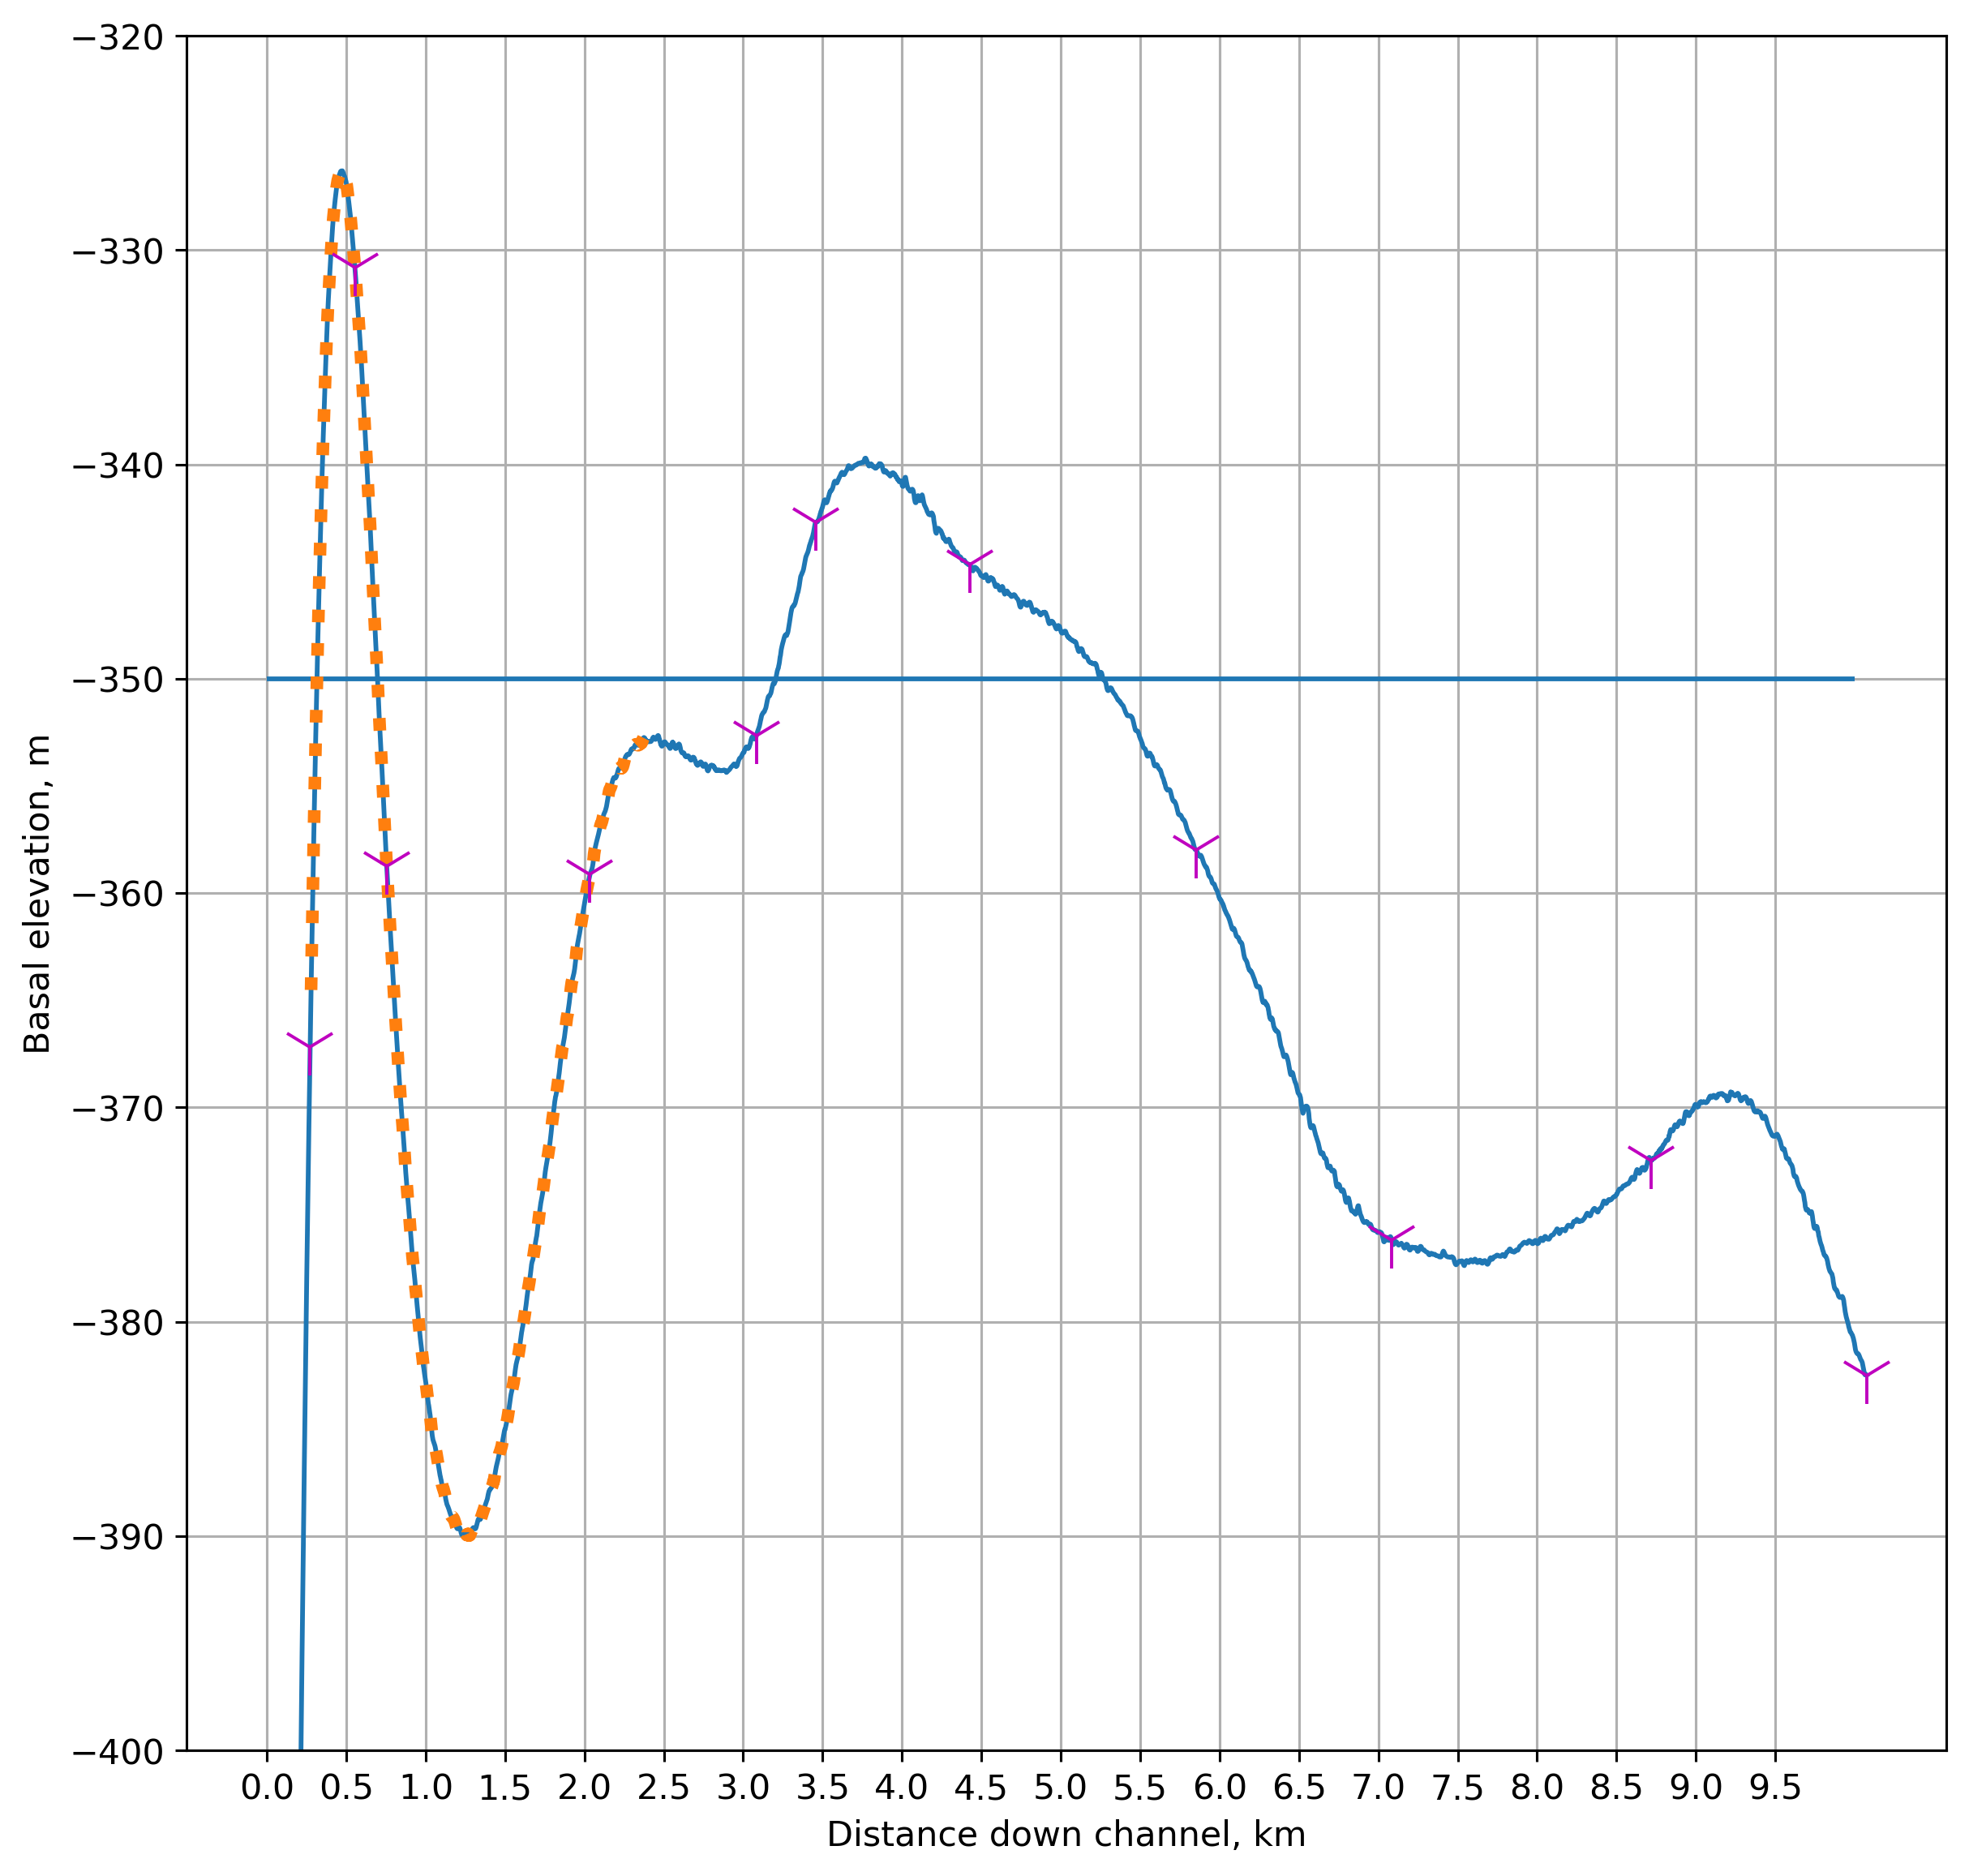

In [51]:

plt.figure(figsize=(10,10),dpi=280)#rema ,constrained_layout=True


plt.plot(gdf_mid.distan_cum/1000,gdf_mid.ice_base+geoid_correction+res_correction + res_correction)
# plt.plot( gdf_mid.distan_cum.iloc[39],gdf_mid.ice_base.iloc[39],'b1',label="downwasting centre",markersize=15,markeredgewidth=2)
plt.plot(gdf_mz.distan_cum/1000,gdf_mz.ice_base+geoid_correction+res_correction + res_correction,':',label="downwasting region",
         color='tab:orange',linewidth=4) #,linewidth=3,markersize=15,markeredgewidth=2,
plt.plot(distan_cum_surveyed/1000,base_surveyed[50,:]+geoid_correction+res_correction + res_correction,'1',
          label="19-20 surveyed points",markersize=18,color="m")
plt.ylim(-400,-320)
plt.hlines(-350,0,10)
plt.yticks(np.arange(-400,-310,10))
plt.xticks(np.arange(0,10,0.5))
plt.ylabel('Basal elevation, m')
plt.xlabel('Distance down channel, km')
plt.grid()


In [37]:
print(points_x_surveyed[50,4],points_y_surveyed[50,4])

-379828.7836872891 -725906.7900945658


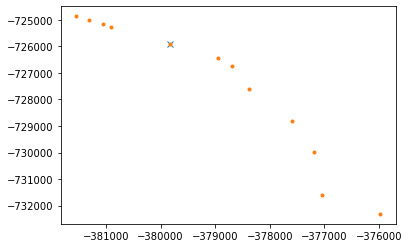

In [36]:
plt.plot(points_x_surveyed[50,4],points_y_surveyed[50,4],'x')
plt.plot(points_x_surveyed[50,:],points_y_surveyed[50,:],'.')

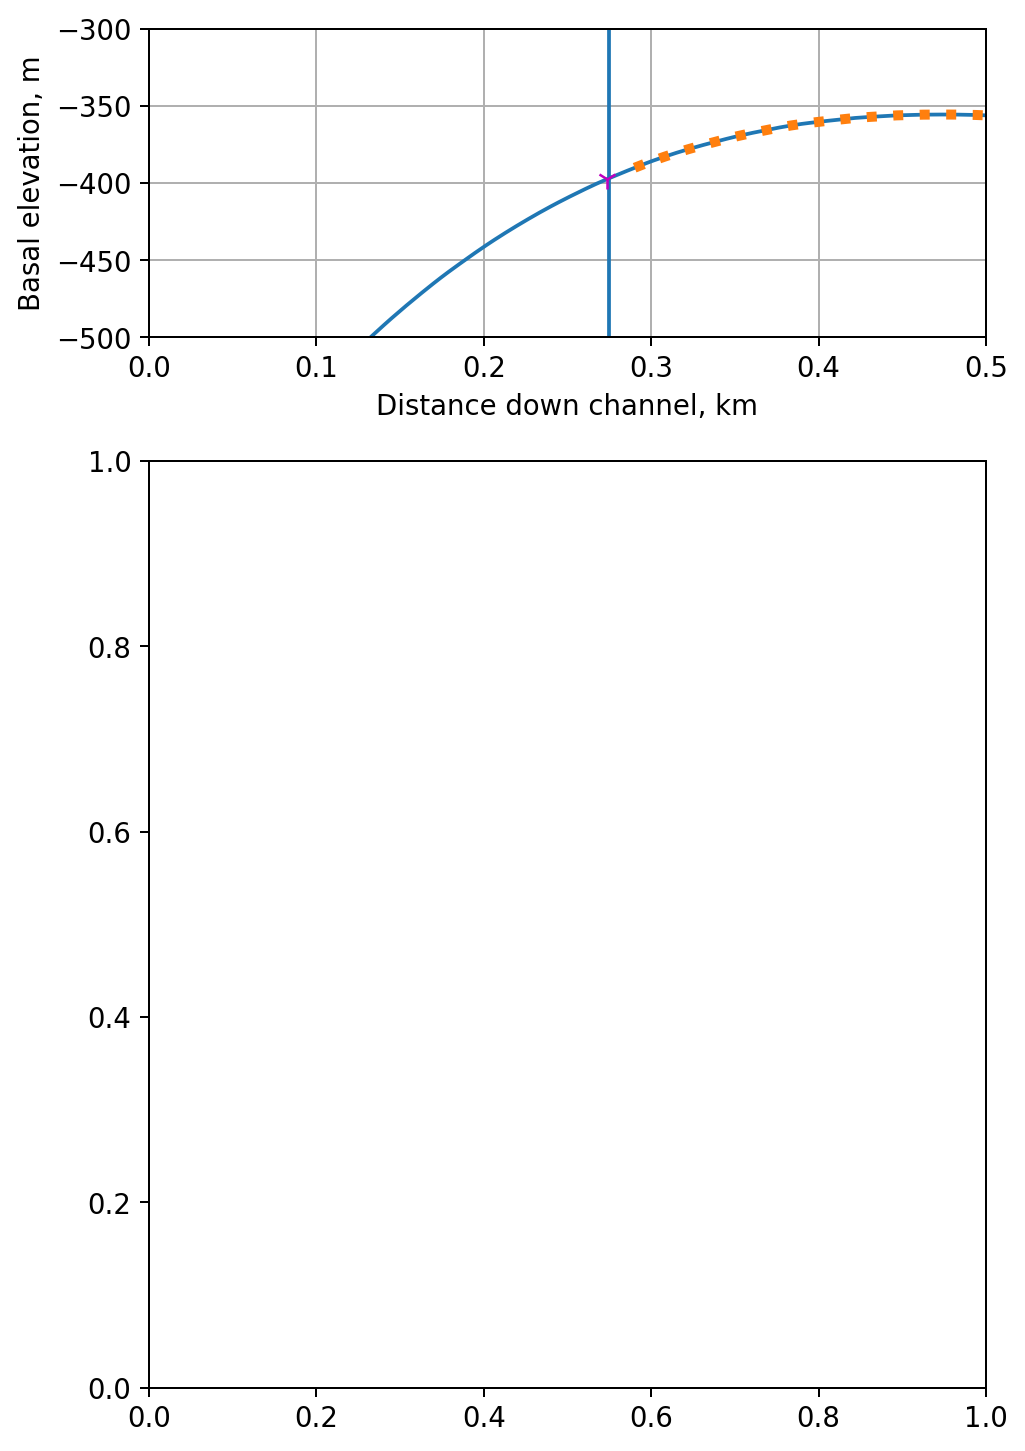

In [36]:
# %matplotlib qt
#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

font = {'size'   : 11}

mpl.rc('font', **font)


fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 3]},
                               figsize=[6,10],dpi=180)#rema ,constrained_layout=True


ax1.plot(gdf_mid.distan_cum/1000,gdf_mid.ice_base)
# ax1.plot( gdf_mid.distan_cum.iloc[39],gdf_mid.ice_base.iloc[39],'b1',label="downwasting centre",markersize=15,markeredgewidth=2)
ax1.plot(gdf_mz.distan_cum/1000,gdf_mz.ice_base,':',label="downwasting region",
         color='tab:orange',linewidth=4) #,linewidth=3,markersize=15,markeredgewidth=2,
ax1.plot(distan_cum_surveyed/1000,base_surveyed[50,:],'1',
          label="19-20 surveyed points",markersize=8,color="m")
ax1.set_xlim([0,0.5])
ax1.vlines(0.275,-500,-300)
ax1.set_ylim([-500,-300])
ax1.set_ylabel('Basal elevation, m')
ax1.set_xlabel('Distance down channel, km')
ax1.grid()



# a2 = ax2.imshow(im_REMA,extent=np.array(extent_REMA)/1000,vmin=25,vmax=80, cmap='BrBG')
# ax2.plot( gdf_mid.x/1000,gdf_mid.y/1000,label='channel maximum')
# ax2.plot(bullseye_array[0]/1000,bullseye_array[1]/1000,':',label="downwasting region",color='tab:orange',linewidth=4) #,markersize=15,markeredgewidth=2
# ax2.plot(gdf_mz.x/1000,gdf_mz.y/1000,':',markersize=4,color='tab:orange',linewidth=3) #,markersize=15,markeredgewidth=2
# ax2.plot(points_x_surveyed[50,:]/1000,points_y_surveyed[50,:]/1000,'1',markersize=8,label="19-20 surveyed points",color="m")
# ax2.set_xlim([xmin/1000, xmax/1000])
# ax2.set_ylim([ymin/1000,ymax/1000])
# ax2.set_xticks(xticks)
# ax2.set_yticks(yticks)
# ax2.grid()
# ax2.set_xlabel('Easting, polar steriographic, km')
# ax2.set_ylabel('Northing, polar steriographic, km')
# # ax2.set_xticks(xgrid/1000)
# ax2.legend()
# cb1 = fig.colorbar(a2,ax=ax2)
# cb1.set_label('Surface elevation, m')
# cb1.set_ticks(np.round(np.linspace(15,90,5)/5)*5)

# (x0, y0), (x1, y1) = ax2.get_position().get_points() 
# (x20, y20), (x21, y21) = ax1.get_position().get_points() 
# ax1.set_position([x0, y20, x1-x0,y21-y20 ])  # x, y, width, height


# fig.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/thickness_surfacecolour.png')
fig.show()

In [27]:
ibb = np.mean(ib_new[45:55,:],axis=0)

In [38]:
gdf_mz.ice_thickn.min()

423.2051756805161

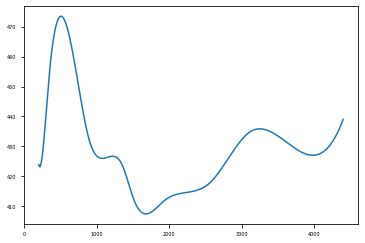

In [43]:
plt.plot(gdf_mid.ice_thickn.iloc[200:])

In [45]:
gdf_mid.ice_thickn.iloc[200:].median()

427.4079620354668

In [47]:
gdf_mid.ice_base.iloc[200:].mean()

-392.7346612400471

In [39]:
gdf_mid.ice_base.iloc[200:].median()

-395.7418908719509

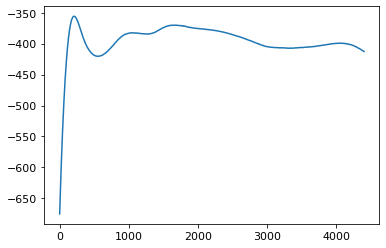

In [37]:
plt.plot(gdf_mid.ice_base)

In [38]:
gdf_mid.ice_base.iloc[0]

-675.2239311578435